In [61]:
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from splinter import Browser
from bs4 import BeautifulSoup as soup
from webdriver_manager.chrome import ChromeDriverManager

executable_path = {'executable_path': ChromeDriverManager().install()}
browser = Browser('chrome', **executable_path, headless=False)

In [62]:
# Set up Splinter
url = 'https://data-class-mars-challenge.s3.amazonaws.com/Mars/index.html'
browser.visit(url)
# Set up the HTML parser
html = browser.html
soup = soup(html, 'html.parser')

In [63]:
html_table = soup.find('table', class_='table')

In [64]:
# Find the headers
headers = html_table.find_all('th')

# Append the headers to a list
tabel_hdrs=[]
for header_elem in headers:
    columns=header_elem.text
    tabel_hdrs.append(columns)

In [65]:
# Convert list to dataframe
mars_df = pd.DataFrame(columns= tabel_hdrs)

In [66]:
# Add data to the dataframe
for row in html_table.find_all('tr', class_='data-row'):
    data = row.find_all('td')
    row_data = [td.text.strip() for td in data]
    table_len=len(mars_df)
    mars_df.loc[table_len]=row_data

In [67]:
#Show the datatypes 
mars_df.dtypes

id                  object
terrestrial_date    object
sol                 object
ls                  object
month               object
min_temp            object
pressure            object
dtype: object

In [68]:
# Update the datatypes
mars_df['id']=mars_df['id'].astype(int)
mars_df['terrestrial_date']=pd.to_datetime(mars_df['terrestrial_date'])
mars_df['sol']=mars_df['sol'].astype(int)
mars_df['ls']=mars_df['ls'].astype(int)
mars_df['month']=mars_df['month'].astype(int)
mars_df['min_temp']=mars_df['min_temp'].astype(float)
mars_df['pressure']=mars_df['pressure'].astype(float)
mars_df.dtypes

id                           int32
terrestrial_date    datetime64[ns]
sol                          int32
ls                           int32
month                        int32
min_temp                   float64
pressure                   float64
dtype: object

In [169]:
mars_df.duplicated().any()

False

In [69]:
# How many months exist on Mars?
months_on_mars= mars_df['month'].nunique()
print(f'There are {months_on_mars} months on Mars.')

There are 12 months on Mars.


In [70]:
# How many Martian (and not Earth) days worth of data exist in the scraped dataset?
martian_days = mars_df['sol'].nunique()
print(f'There are {martian_days} Martian days worth of data in the dataset.')

There are 1867 Martian days worth of data in the dataset.


In [85]:
# Average the minimum daily temperature of all the months
temp_df= mars_df.groupby('month', as_index=False).mean().sort_values('month')
temp_df

,month,id,sol,ls,min_temp,pressure
0,1,1013.873563,1077.574713,15.281609,-77.160920,862.488506
1,2,1109.882022,1175.853933,44.258427,-79.932584,889.455056
2,3,1132.697917,1204.406250,75.010417,-83.307292,877.322917
3,4,1175.164948,1244.500000,104.365979,-82.747423,806.329897
4,5,1115.033557,1182.691275,132.885906,-79.308725,748.557047
5,6,735.306122,750.829932,164.897959,-75.299320,745.054422
6,7,714.549296,715.105634,194.894366,-72.281690,795.105634
7,8,718.078014,795.333333,224.347518,-68.382979,873.829787
8,9,785.843284,861.186567,254.052239,-69.171642,913.305970
9,10,955.723214,1034.669643,286.330357,-71.982143,887.312500


In [157]:
# What on average are the coldest and the warmest months on Mars?
min_temp= temp_df['min_temp'].min()
max_temp= temp_df['min_temp'].max()
cold_month = temp_df['month'].loc[temp_df['min_temp']==min_temp]
warm_month = temp_df['month'].loc[temp_df['min_temp']==max_temp]
print(f'The cold months are {cold_month.to_string()}, and the warm months are {warm_month.to_string()}.')

The cold months are 2    3, and the warm months are 7    8.


Text(0.5, 1.0, 'Mars Min Temp by Month')

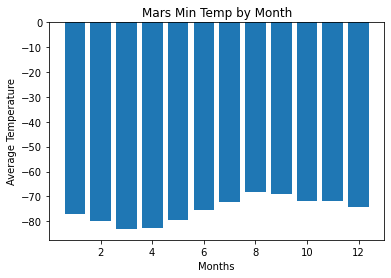

In [104]:
# Plot the results as a bar chart.
plt.bar(temp_df['month'], temp_df['min_temp'])
plt.xlabel("Months")
plt.ylabel("Average Temperature")
plt.title('Mars Min Temp by Month')

In [159]:
# Which months on average have the lowest and the highest atmospheric pressure on Mars? 
low_pressure= temp_df['pressure'].min()
high_pressure= temp_df['pressure'].max()
low_pressure_month = temp_df['month'].loc[temp_df['pressure']==low_pressure]
high_pressure_month = temp_df['month'].loc[temp_df['pressure']==high_pressure]
print(f'The average low pressure months are {low_pressure_month.to_string()}, and the average high pressure months are {high_pressure_month.to_string()}.')

The average low pressure months are 5    6, and the average high pressure months are 8    9.


Text(0.5, 1.0, 'Mars Average Pressure by Month')

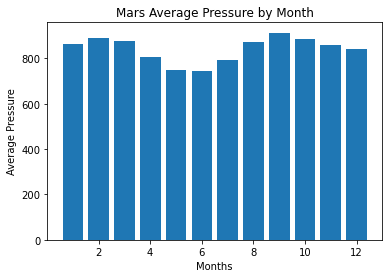

In [158]:
# Plot the results as a bar chart.
plt.bar(temp_df['month'], temp_df['pressure'])
plt.xlabel("Months")
plt.ylabel("Average Pressure")
plt.title('Mars Average Pressure by Month')

In [110]:
#About how many terrestrial (Earth) days exist in a Martian year? 

#Mars Longitude at the start
mars_year_start=mars_df['ls'].loc[0]

#Find the all instances of the same longitude 
martian_sols=mars_df.loc[mars_df['ls']==mars_year_start]
martian_sols

,id,terrestrial_date,sol,ls,month,min_temp,pressure
0,2,2012-08-16,10,155,6,-75.0,739.0
598,621,2014-07-03,678,155,6,-77.0,739.0
599,624,2014-07-04,679,155,6,-77.0,738.0
1249,1274,2016-05-20,1346,155,6,-75.0,737.0
1250,1277,2016-05-21,1347,155,6,-75.0,736.0


In [166]:
#Find the difference in Sols with the same Longitude to find Earth days passed estimate
martians_sols_passed = mars_df['sol'].loc[1250]-mars_df['sol'].loc[598]
print(f'Mars circles the Sun about every {martians_sols_passed} Earth days.')

Mars circles the Sun about every 669 Earth days.


Text(0.5, 1.0, 'Daily Min Temp to Estimate Mars years in Earth Days')

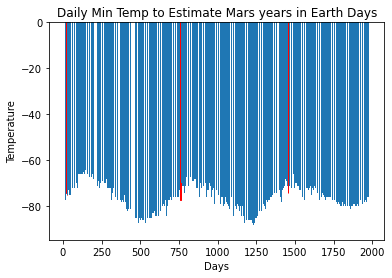

In [165]:
# Estimate the result by plotting the daily minimum temperature.
estimated_years= plt.bar(mars_df['sol'], mars_df['min_temp'])
estimated_years[9].set_color('r')
estimated_years[10].set_color('r')
estimated_years[678].set_color('r')
estimated_years[679].set_color('r')
estimated_years[1346].set_color('r')
estimated_years[1347].set_color('r')
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.title('Daily Min Temp to Estimate Mars years in Earth Days')

In [168]:
# Export the DataFrame to a CSV file
mars_df.to_csv('mars_table.csv',index=False)